## 模块导入

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn.naive_bayes import GaussianNB #Naive bayes

warnings.filterwarnings('ignore')
try:
    os.makedirs('pictures') # 创建保存图片的文件夹
    os.makedirs('pictures\\model_cm')
    os.makedirs('pictures\\model_lc')
    os.makedirs('pictures\\model_roc')
except Exception as err:
    print(err)

[WinError 183] 当文件已存在时，无法创建该文件。: 'pictures'


## 工具类

### 数据获取

In [2]:
class GetData:
    def __init__(self):
        self.__train_data = pd.read_excel('./Data.xlsx', sheet_name=0)
        self.__test_data = pd.read_excel('./Data.xlsx', sheet_name=1)
        
    @property 
    def train_data(self):
        self.__train_data.rename(columns = {"是否含有特定成分(1为含有，0为不含)": "label"}, inplace=True)
        return self.__train_data
    
    @property
    def test_data(self):
        return self.__test_data
        
        

### 数据可视化

In [3]:
class Visualization:
    """
    数据可视化类，对原始数据可视化，以作为预处理的参考
    """
    def __init__(self):
        pass
    
    @classmethod
    def show_pairplot(cls, data):
        sns.pairplot(data = data, vars=data.iloc[:, :-1], hue='label', palette='husl')
        plt.show()
        return
        
    @classmethod
    def show_hist(cls, df_final, col_num):
#         %matplotlib notebook
#         %matplotlib inline

        plt.figure(figsize = (10, 6), dpi = 80)
#         plt.hist(df_final.iloc[: , col_num][df_final['label'] == 1], alpha = 0.6 )
#         plt.hist(df_final.iloc[: , col_num][df_final['label'] == 0], alpha = 0.6 )
        sns.distplot(df_final.iloc[: , col_num][df_final['label'] == 1], color = 'r', label = '1')
        sns.distplot(df_final.iloc[: , col_num][df_final['label'] == 0], color = 'b', label = '0')
        plt.title(list(df_final.columns)[col_num])
        plt.legend()
        plt.grid()
        plt.show()
        return
    
    @classmethod
    def show_corr(cls, data):
        
        plt.figure(figsize = (12, 8))
        sns.heatmap(data.corr(), annot=True, cmap=plt.cm.rainbow, linewidths=0.2) #data.corr()-->correlation matrix
        plt.show()
        return    

### 数据预处理

In [4]:

class PCA:
    def __init__(self, k = 3):
        self.k = k
        self.ew_sort = None
        self.ev_sort = None
        self.V = None
        
    def norm_(self, data):
        """
        normalization
        """
        mean = np.mean(data, axis = 0)
        std = np.std(data, axis = 0)
        return (data-mean)/std
    
    def fit(self, data):
        data = self.norm_(data)
        # V
        ew, ev = np.linalg.eig(np.cov(data.T))
        # print(ew)
        # print(ev)
        ew_order = np.argsort(ew)[::-1]
        self.ew_sort = ew[ew_order]
        self.ev_sort = ev[:, ew_order]
#         print(ew_sort)
#         print(ev_sort)
#         pd.DataFrame(ew_sort).plot(kind = 'bar')  
        return self.ew_sort, self.ev_sort

    def transform(self, data):
        data = self.norm_(data)
        # V
        self.V = self.ev_sort[:, :self.k]
        # Xnew
        X_new = data.dot(self.V)
        
        return X_new
        
    def show_ew(self):
        pd.DataFrame(self.ew_sort).plot(kind = 'bar')
        return 

### 参数择优

In [5]:
class ParamSelect:
    """
    参数寻优类，输入模型及训练集数据，经过网格搜索及交缠验证后，返回最优模型参数
    """
    
    def __init__(self, train_x, train_y, clf = None):
        # 训练集 train_x, train_y
        assert train_x.shape[0] == train_y.shape[0], '特征集和标签长度不一致！'
        self.train_x, self.train_y = train_x, train_y
        # 模型
        self.clf = clf
        
        
    def get_best_param(self, param_grid: list) -> dict:
        """
        :param param_grid: 代调优模型参数列表
        :return: 最优的模型参数best_params_
        """
        # 交叉验证参数择优  
        kfold_gs = StratifiedKFold(n_splits=10, random_state=0)
        # 网格搜索
        grid_search = GridSearchCV(estimator=self.clf,
                param_grid=param_grid,
                scoring='f1_weighted',
                cv=kfold_gs)
#         scores = cross_val_score(grid_search,self.train_x, self.train_y,scoring='accuracy',cv=kfold_cv)
#         print("CV average Accuracy in Train Phase: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))
        grid_result = grid_search.fit(self.train_x, self.train_y)
        print("参数寻优：\nBest score: %f using %s" % (grid_result.best_score_, grid_search.best_params_))
        return grid_search.best_params_


### 模型评估

In [6]:
class ModelEvaluation:
    """
    模型评估类，对用最佳参数训练的模型，用10折交叉验证，混淆矩阵等方法对模型进行评估，判断模型的优劣。
    """
    
    def __init__(self, clf, test_x, test_y):
        # 模型
        self.clf = clf
        # 总的特征数据
        assert test_x.shape[0] == test_y.shape[0], '特征集和标签长度不一致！'
        self.test_x = test_x
        self.test_y = test_y

    def kfold_cv(self) -> float:
        """
        用在训练集上的最佳参数训练模型后，在测试集（test_x, test_y ： 对模型来说是全新的数据）上进行十折交叉验证，检验模型的好坏
        :param:
        :return: 10折交叉验证后返回f1_score_weighted
        """
        kfold_cv  = StratifiedKFold(n_splits=10, random_state=0)
        # 考虑类别的不平衡性，需要计算类别的加权平均，使用'f1_weighted'而不是f1
        scores = cross_val_score(self.clf, self.test_x, self.test_y, scoring='f1_weighted', cv=kfold_cv)
        print("交叉验证：\n10fold cross validation f1_weighted score in final model: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))
        return np.mean(scores)
    
    @classmethod   
    def get_f1_score(cls, test_y, pred_y) -> float:
        """
        :param test_y, pred_y: 真实值和预测值
        :return: 根据真实值和预测值计算f1_score
        """
        assert test_y.shape[0] == pred_y.shape[0], '测试集和预测集长度不一致！'
        f1_score_wei = f1_score(test_y, pred_y, average='weighted')      
        return f1_score_wei
    
    @classmethod  
    def show_learning_curve(cls, X, y, clf, title):
        """
        绘制学习曲线：根据训练样本大小的变化，展示分类准确率的改变
        :param clf: 待评估模型
        :return:  
        """
        assert X.shape[0] == y.shape[0]
        print('Learning curve:')
        plt.figure(figsize=(8, 6))
        # 模型
        clf = clf  
        lw = 2
        title = title
        plt.title(title)
        # 设置y轴坐标
        plt.ylim((.3, 1.01))
        plt.xlabel("Training samples")
        plt.ylabel("Score")
        # 获得绘图数据
        cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
        train_sizes, train_scores, test_scores = learning_curve(
            clf, X, y, cv=cv, train_sizes=np.linspace(0.1, 1, 10))
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        # 画图
        plt.plot(train_sizes, train_scores_mean, 'o-', color="pink", lw=lw,
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="lightgreen", lw=lw,
                 label="Cross-validation score")
        plt.grid()
        plt.legend(loc="best")
        plt.savefig('pictures\\model_lc\\' + title)
        plt.show()
        return
    
    @classmethod
    def show_confusion_matrix(cls, test_y, pred_y, model_name: str, classes = ['0','1'],  cmap=plt.cm.rainbow):
        """
         根据真实值和预测值画出混淆矩阵
        :param test_y, pred_y: 真实值和预测值
        :param model_name: 模型名
        :return: 
        """
        title = str(model_name) + '_confusion_matrix'
        plt.rc('font',size='13')   # 设置字体大小
        cm = confusion_matrix(test_y, pred_y)
        print("confusion matrix:\n",cm)
        # 按行进行归一化
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) == 0:
                    cm[i, j]=0

        fig, ax = plt.subplots(figsize = (7, 5), dpi = 80)
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带

        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='Actual',
               xlabel='Predicted')

        # 通过绘制格网，模拟每个单元格的边框
        ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # 将x轴上的lables旋转45度
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # 标注百分比信息
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) > 0:
                    ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                            ha="center", va="center",
                            color="white"  if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.savefig('pictures\\model_cm\\' + title)
        plt.show()
        return 
        
    @classmethod
    def show_classification_report(cls, test_y, pred_y):
        """
        根据真实值和预测值打印分类报告
        :param test_y, pred_y: 真实值和预测值
        :return: 
        """
        assert test_y.shape[0] == pred_y.shape[0], '测试集和预测集长度不一致！'
        print("Detailed classification report:")
        print(classification_report(test_y, pred_y))
        return 
        
    @classmethod
    def my_pipeline(cls, train_x, train_y, test_x, test_y, X, y, clf, model_name: str) -> float:
        """
        自定义流水线方法，执行模型评估工作
        :param clf: 分类模型
        :param model_name: 模型名称
        :return:
        """
        # 在测试集（test_x, test_y）全新的数据上做十折交叉验证，评估验证模型
        modelevaluation = ModelEvaluation(clf, test_x, test_y)
        clf.fit(train_x,train_y)
        pred_y = clf.predict(test_x)
        cv_f1_score = modelevaluation.kfold_cv()
        test_f1_score = ModelEvaluation.get_f1_score(test_y, pred_y)
        print('cv-f1-score:', cv_f1_score)
        print('test-f1-score:', test_f1_score)
        ModelEvaluation.show_classification_report(test_y, pred_y)
        ModelEvaluation.show_confusion_matrix(test_y, pred_y, model_name)
        ModelEvaluation.show_learning_curve(X, y, clf,  model_name)
        
        return cv_f1_score
    
    @classmethod
    def show_roc_curve(cls, test_y, y_score, model_name):
        """
        roc 曲线
        """
        
        
        # Compute ROC curve and ROC area for each class
        fpr,tpr,threshold = roc_curve(test_y, y_score) ###计算真正率和假正率
        roc_auc = auc(fpr,tpr) # 计算auc的值 AUC的含义：ROC曲线下的面积（越大越好，1为理想状态）
        plt.figure()
        lw = 3
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color='r',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(model_name + 'Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('pictures\\model_roc\\' + model_name + '_Receiver operating characteristic')
        plt.show()
        return 
    @classmethod
    def get_test_result(cls, clf, test_data, model_name):
        return pd.DataFrame(clf.predict(test_data), columns = [model_name+'_pred_y'])

## 建模

In [7]:
def show_model_status(model_name: str):
    """
    打印当前训练模型
    :param model_name: 模型名称
    :return:
    """
    assert isinstance(model_name, str), 'model_name必须为字符串类型！'
    print('-'*100)
    print(model_name, '模型训练及评估：')
    return 
model_list = ['DecisionTree', 'Svm', 'Knn']
# 用来记录每个模型10折交叉验证f1分数的DataFrame
df_score = pd.DataFrame(columns = ['cv_f1_score', 'accuracy'])
# 记录测试数据前10条预测值
df_pred = pd.DataFrame()

### 获取数据

In [8]:
get_data = GetData()
df_final = get_data.train_data
df_test = get_data.test_data

In [9]:
df_final.head()

,V1,V2,V3,V4,V5,V6,V7,label
0,0.535424,0.910960,0.524026,0.992520,0.837432,0.895676,0.632646,1
1,0.431184,0.763346,0.350371,0.885103,0.532782,0.926587,0.621668,1
2,0.857351,0.963743,0.723323,0.997718,0.850043,0.732553,0.437323,1
3,0.013346,0.098378,0.008714,0.781759,0.414321,0.817683,0.410796,0
4,-0.005583,0.056952,-0.016080,0.628570,0.401985,0.704188,0.400392,0


In [10]:
df_final.describe()

,V1,V2,V3,V4,V5,V6,V7,label
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.379799,0.581811,0.317147,0.881700,0.590638,0.804141,0.449740,0.694750
std,0.313877,0.331197,0.291529,0.131421,0.210565,0.126345,0.123931,0.460525
min,-0.752723,-0.062687,-1.261943,0.320840,0.134443,0.183343,0.118308,0.000000
25%,0.016551,0.220954,0.013827,0.800967,0.405840,0.721750,0.355693,0.000000
50%,0.468211,0.735289,0.347197,0.943091,0.564188,0.823860,0.434033,1.000000
75%,0.639390,0.868181,0.568549,0.987442,0.783371,0.908167,0.533794,1.000000
max,0.965002,0.985052,0.920936,0.999775,0.994328,0.999482,0.847895,1.000000


### 数据可视化

#### 直方图

In [11]:
%matplotlib inline

In [12]:
list(df_final.columns)[:-1]

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

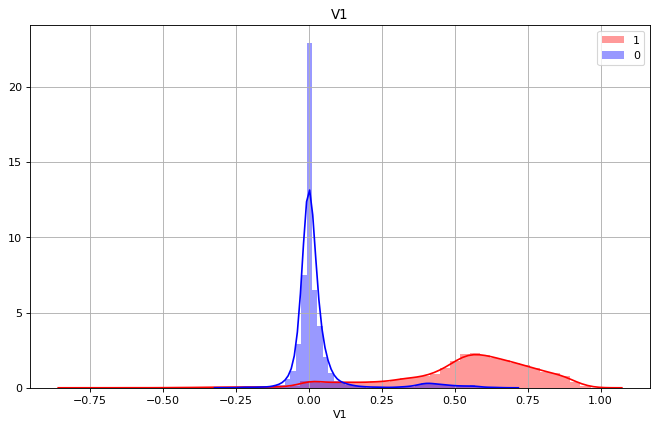

In [13]:
Visualization.show_hist(df_final, 0)

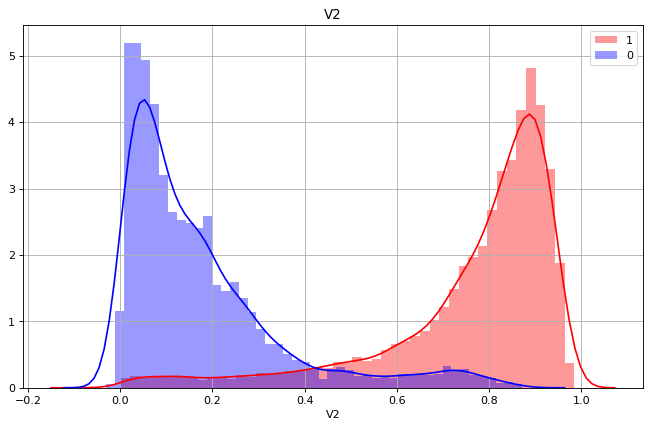

In [14]:
Visualization.show_hist(df_final, 1)

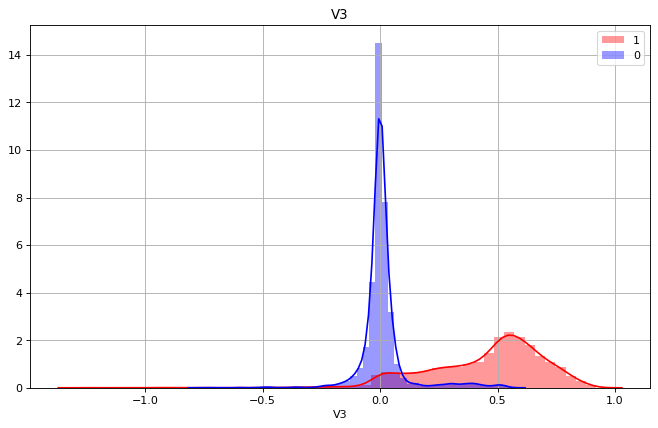

In [15]:
Visualization.show_hist(df_final,2)

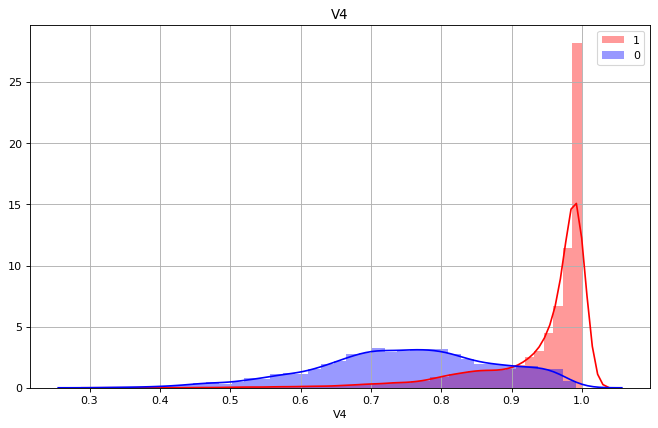

In [16]:
Visualization.show_hist(df_final, 3)

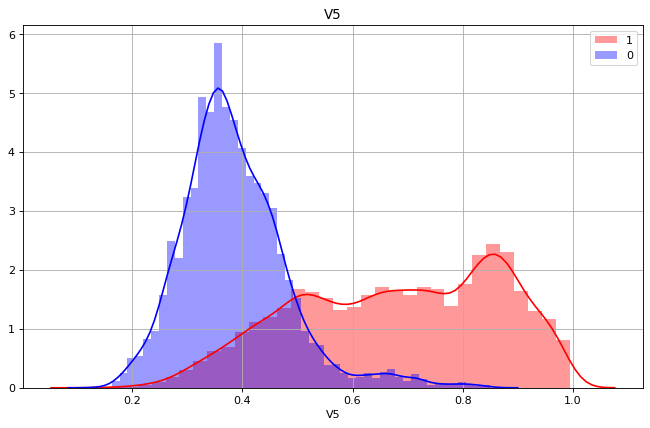

In [17]:
Visualization.show_hist(df_final, 4)

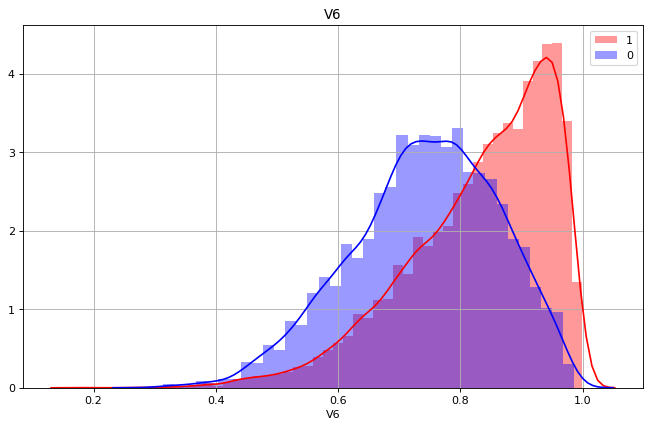

In [18]:
Visualization.show_hist(df_final, 5)

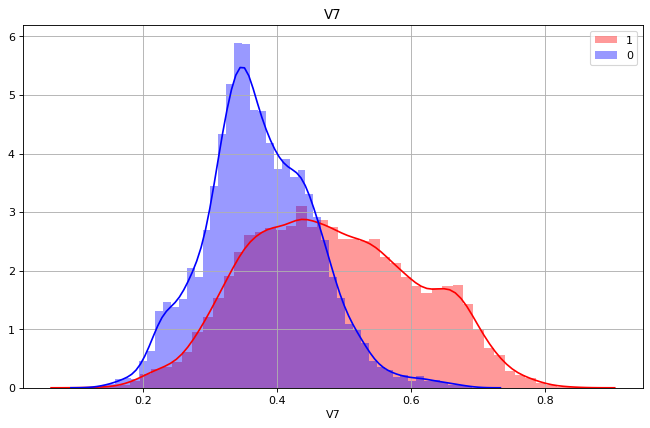

In [19]:
Visualization.show_hist(df_final, 6)

#### 查看特征相关性

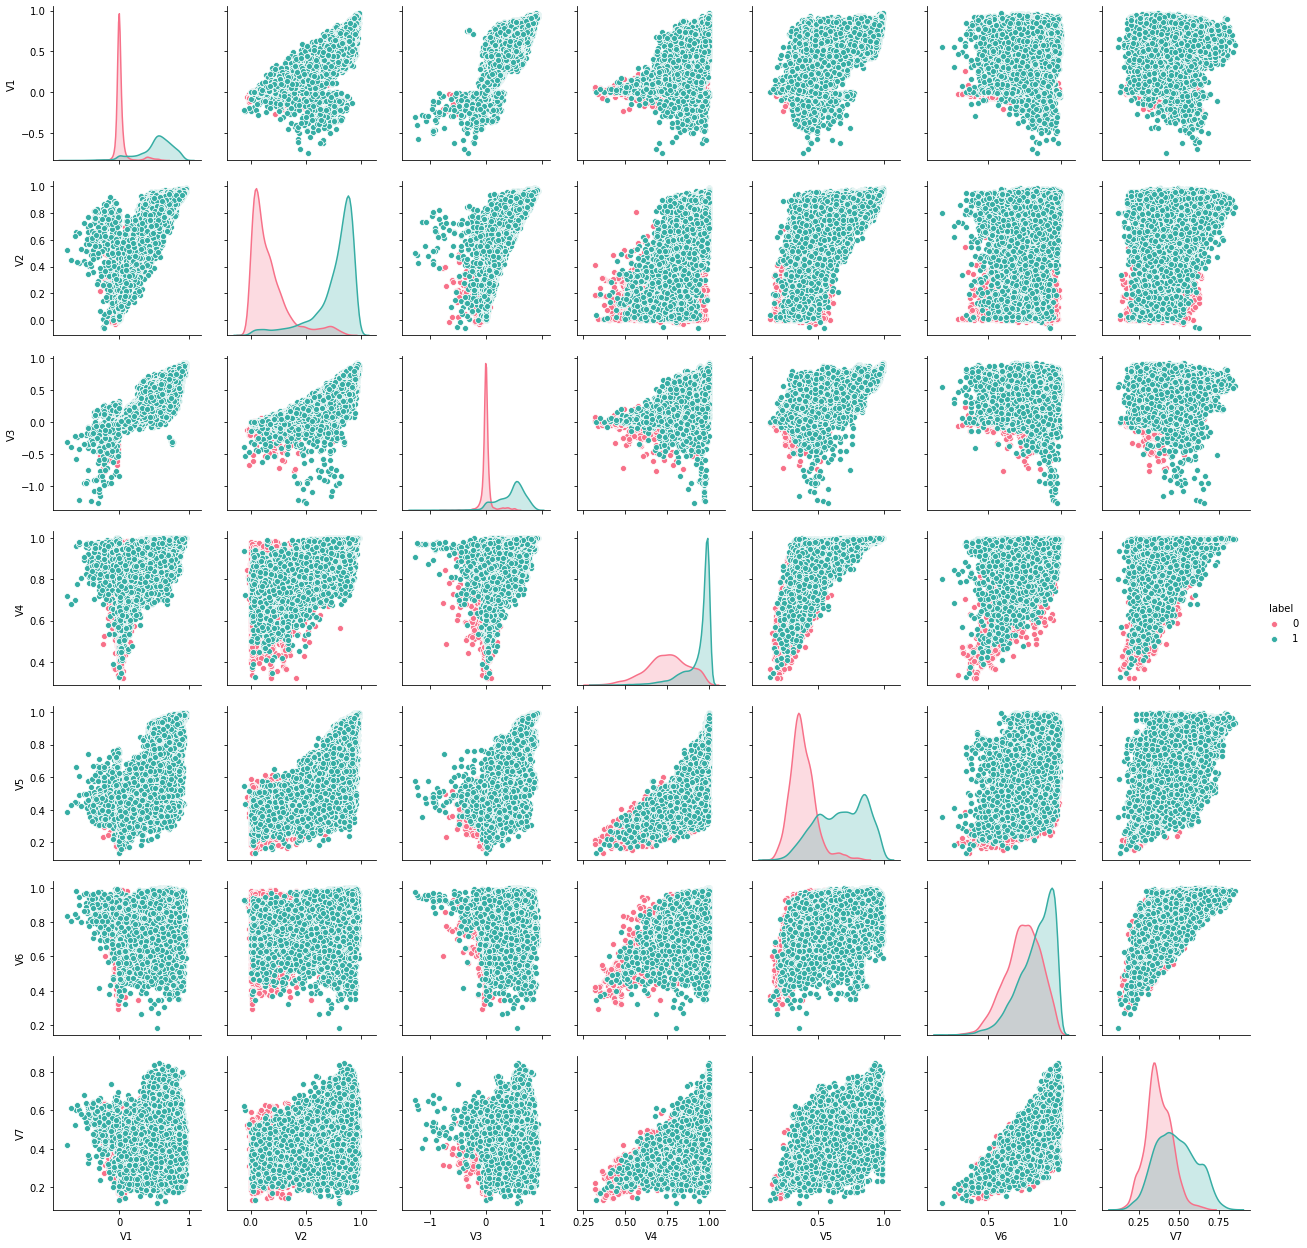

In [20]:
Visualization.show_pairplot(df_final)

#### 相关系数矩阵

In [21]:
# 通过相关系数矩阵（各个指标与标签0/1的相关程度），判断出可以判定特定成分存在的主要指标；
df_final.corr()[df_final.corr()['label'] > 0.5]

,V1,V2,V3,V4,V5,V6,V7,label
V1,1.000000,0.908051,0.932456,0.738010,0.798685,0.314911,0.376077,0.745024
V2,0.908051,1.000000,0.873408,0.791787,0.801841,0.387905,0.465767,0.819360
V3,0.932456,0.873408,1.000000,0.714739,0.840902,0.306695,0.399386,0.695535
V4,0.738010,0.791787,0.714739,1.000000,0.792374,0.657680,0.600046,0.662179
V5,0.798685,0.801841,0.840902,0.792374,1.000000,0.532812,0.653407,0.644711
label,0.745024,0.819360,0.695535,0.662179,0.644711,0.331616,0.400044,1.000000


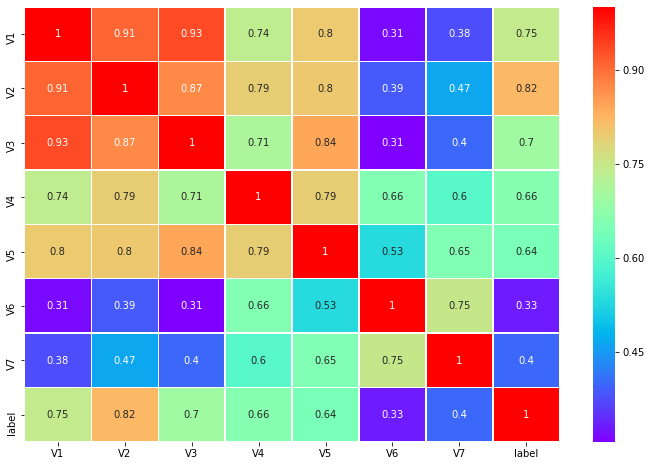

In [22]:
Visualization.show_corr(df_final)

In [23]:
df_final.describe()

,V1,V2,V3,V4,V5,V6,V7,label
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.379799,0.581811,0.317147,0.881700,0.590638,0.804141,0.449740,0.694750
std,0.313877,0.331197,0.291529,0.131421,0.210565,0.126345,0.123931,0.460525
min,-0.752723,-0.062687,-1.261943,0.320840,0.134443,0.183343,0.118308,0.000000
25%,0.016551,0.220954,0.013827,0.800967,0.405840,0.721750,0.355693,0.000000
50%,0.468211,0.735289,0.347197,0.943091,0.564188,0.823860,0.434033,1.000000
75%,0.639390,0.868181,0.568549,0.987442,0.783371,0.908167,0.533794,1.000000
max,0.965002,0.985052,0.920936,0.999775,0.994328,0.999482,0.847895,1.000000


#### 连续值离散化

In [24]:
k = 10
one = pd.cut(df_final.iloc[:, 0], k, labels = range(k))

In [25]:
# one

In [26]:
temp = pd.DataFrame(one)

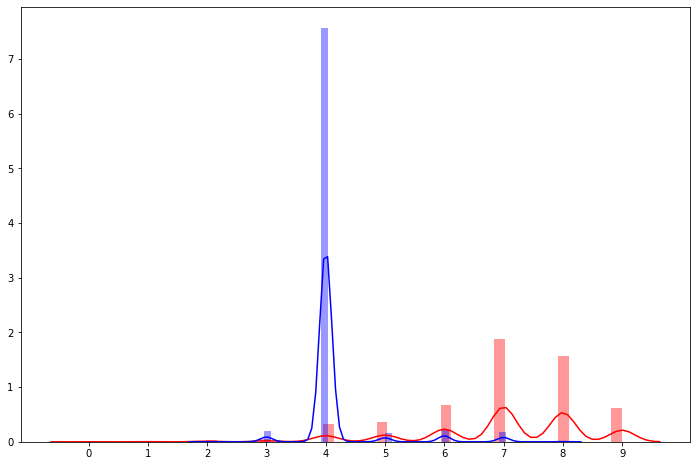

In [27]:
plt.figure(figsize = (12, 8))
sns.distplot(temp[df_final['label'] == 1], color = 'r', label = '1')
sns.distplot(temp[df_final['label'] == 0], color = 'b', label = '0')
plt.xticks(list(range(10)))
plt.show()

In [28]:
for i in range(10):
    print(str(i) +':'+ str(abs(temp[temp['V1'] == i][df_final['label'] == 0].count() - temp[temp['V1'] == i][df_final['label'] == 1].count())))

0:V1    6
dtype: int64
1:V1    21
dtype: int64
2:V1    82
dtype: int64
3:V1    2
dtype: int64
4:V1    4725
dtype: int64
5:V1    791
dtype: int64
6:V1    1532
dtype: int64
7:V1    4581
dtype: int64
8:V1    3933
dtype: int64
9:V1    1567
dtype: int64


In [29]:
temp[temp['V1'] == i][df_final['label'] == 1].count()[0]

1567

In [30]:
(temp[temp['V1'] == i][df_final['label'] == 0].count()[0], temp[temp['V1'] == i][df_final['label'] == 1].count()[0])

(0, 1567)

In [31]:
max(0,6)

6

In [32]:
max((temp[temp['V1'] == i][df_final['label'] == 0].count()[0], temp[temp['V1'] == i][df_final['label'] == 1].count()[0]))

1567

In [33]:
temp[temp['V1'] == i][df_final['label'] == 1].count()

V1    1567
dtype: int64

In [39]:
for i in range(10):
    temp_1 = max(temp[temp['V1'] == i][df_final['label'] == 0].count()[0], temp[temp['V1'] == i][df_final['label'] == 1].count()[0])
    temp_2 = min(temp[temp['V1'] == i][df_final['label'] == 0].count()[0], temp[temp['V1'] == i][df_final['label'] == 1].count()[0])
    print(str(i) + str((temp_1/temp_2) > 0.4 * temp_1))

0True
1True
2True
3False
4False
5False
6False
7False
8False
9True


In [ ]:
df_final.iloc[: , 0][df_final['label'] == 1].dtype

In [ ]:
sns.distplot(pd.DataFrame(df_final.iloc[: , 0][df_final['label'] == 1]), color = 'r', label = '1')

#### 特征选择

### 数据预处理

#### PCA 降维

In [ ]:
pca = PCA(5)
pca.fit(df_final.iloc[:, :-1])
X_new = pca.transform(df_final.iloc[:, :-1])
df_test = pca.transform(df_test)
df_new = pd.concat([X_new, df_final.iloc[:, -1:]], axis=1)
df_new.head()
# pca.show_ew()

In [ ]:
# scatter
plt.figure(figsize = (12, 8))
sc = plt.scatter(X_new.iloc[:, 0], X_new.iloc[:, 1], c=df_final.label, cmap = plt.cm.rainbow_r, alpha = 0.4)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.colorbar(sc)
plt.show()
# V 第一列 对应 PC 0 前面的 系数   第二列 对应 PC 1 前面的系数
print(pca.V)
print(df_final.columns)


#### 数据集划分

In [ ]:
X, y = df_new.iloc[:, :-1], df_new.iloc[:, -1:]  # 除标签列之外的特征

print('总特征集X大小：{}, 总标签y大小：{}'.format(X.shape, y.shape))

# 数据集划分
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)
# 标准化 / 归一化
# mms = MinMaxScaler()
# mms.fit(X)
# train_x = mms.transform(train_x)
# test_x = mms.transform(test_x)
# X = mms.transform(X)


# sc = StandardScaler()
# sc.fit(X)
# train_x_std = sc.transform(train_x)
# test_x_std = sc.transform(test_x)
# df_test_std = sc.transform(df_test.iloc[:, :3])
# X_std = sc.transform(X)

print('train_x：{}, train_y:{}, test_x:{}, test_y: {} '.format(train_x.shape, train_y.shape, test_x.shape,
                                                              test_y.shape))
# print('总测试集：', test_final.shape)

### 模型训练

#### DecisionTree

In [ ]:
show_model_status(model_list[0])
# 参数寻优
param_grid_tree = [{'random_state':[0],'criterion':['gini','entropy'], 'max_depth':list(range(2,10,2)),'max_leaf_nodes':list(range(8,40,5))}]
paramselect = ParamSelect(train_x, train_y, DecisionTreeClassifier())
best_param_tree = paramselect.get_best_param(param_grid_tree)

In [ ]:
# 用最优参数训练模型
clf = DecisionTreeClassifier(**best_param_tree)
df_score.loc[model_list[0], 'cv_f1_score'], df_score.loc[model_list[0], 'accuracy']= ModelEvaluation.my_pipeline(train_x, train_y, test_x, test_y, X, y, clf, model_list[0]), clf.score(test_x, test_y)

In [ ]:
# roc 曲线
ModelEvaluation.show_roc_curve(test_y, clf.predict_proba(test_x)[:, 1], model_list[0])

In [ ]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf, df_test.iloc[:, :], model_list[0]).head(10)], axis = 1)

#### KNN

In [ ]:
show_model_status(model_list[2])
param_grid_knn = [{'n_neighbors':list(range(8,12))}]
# 选择最优参数
paramselect = ParamSelect(train_x, train_y, KNeighborsClassifier())
best_param_knn = paramselect.get_best_param(param_grid_knn)

In [ ]:
# 用最优参数训练模型
clf = KNeighborsClassifier(**best_param_knn)
df_score.loc[model_list[1], 'cv_f1_score'], df_score.loc[model_list[1], 'accuracy']= ModelEvaluation.my_pipeline(train_x, train_y, test_x, test_y, X, y, clf, model_list[1]), clf.score(test_x, test_y)

In [ ]:
# roc曲线
ModelEvaluation.show_roc_curve(test_y, clf.predict_proba(test_x)[:, 1], model_list[1])

In [ ]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf, df_test.iloc[:, :], model_list[1]).head(10)], axis = 1)

#### SVM

In [ ]:
show_model_status(model_list[1])
# 给定超参数范围
# {'C': param_range_svm, 'kernel': ['rbf'], 'gamma':param_range_svm}
# {'C': param_range_svm, 'kernel': ['linear']}
param_range_svm = [ 0.1, 1]
param_grid_svm = [{'C': param_range_svm, 'kernel': ['rbf'], 'gamma':param_range_svm}]
# 选择最优参数
paramselect = ParamSelect(train_x, train_y, svm.SVC())
best_param_svm = paramselect.get_best_param(param_grid_svm)

In [ ]:
# 用最优参数训练模型
clf = svm.SVC(**best_param_svm, probability=True)
df_score.loc[model_list[2], 'cv_f1_score'], df_score.loc[model_list[2], 'accuracy']= ModelEvaluation.my_pipeline(train_x, train_y, test_x, test_y, X, y, clf, model_list[2]), clf.score(test_x, test_y)

In [ ]:
# roc 曲线
ModelEvaluation.show_roc_curve(test_y, clf.predict_proba(test_x)[:, 1], model_list[2])

In [ ]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf, df_test.iloc[:, :], model_list[2]).head(10)], axis = 1)

### 最终结果

In [ ]:
df_score

In [ ]:
df_pred

In [ ]:
df_score.sort_values(by='cv_f1_score', ascending = False)